# Graph RAG Cookbook

You can also check this cookbook in colab [here](https://colab.research.google.com/drive/1uZKQSuu0qW6ukkuSv9TukLB9bVaS1H0U?usp=sharing)

This cookbook walks you through the process of performing graph-based Retrieval-Augmented Generation (RAG) using **CAMEL**, powered by the advanced **Mistral** models. Specifically, we'll utilize the **Mistral Large 2** model to extract and structure knowledge from a given content source, and store this information in a **Neo4j** graph database. Subsequently, we can leverage a hybrid approach, combining vector retrieval and knowledge graph retrieval, to query and explore the stored knowledge.

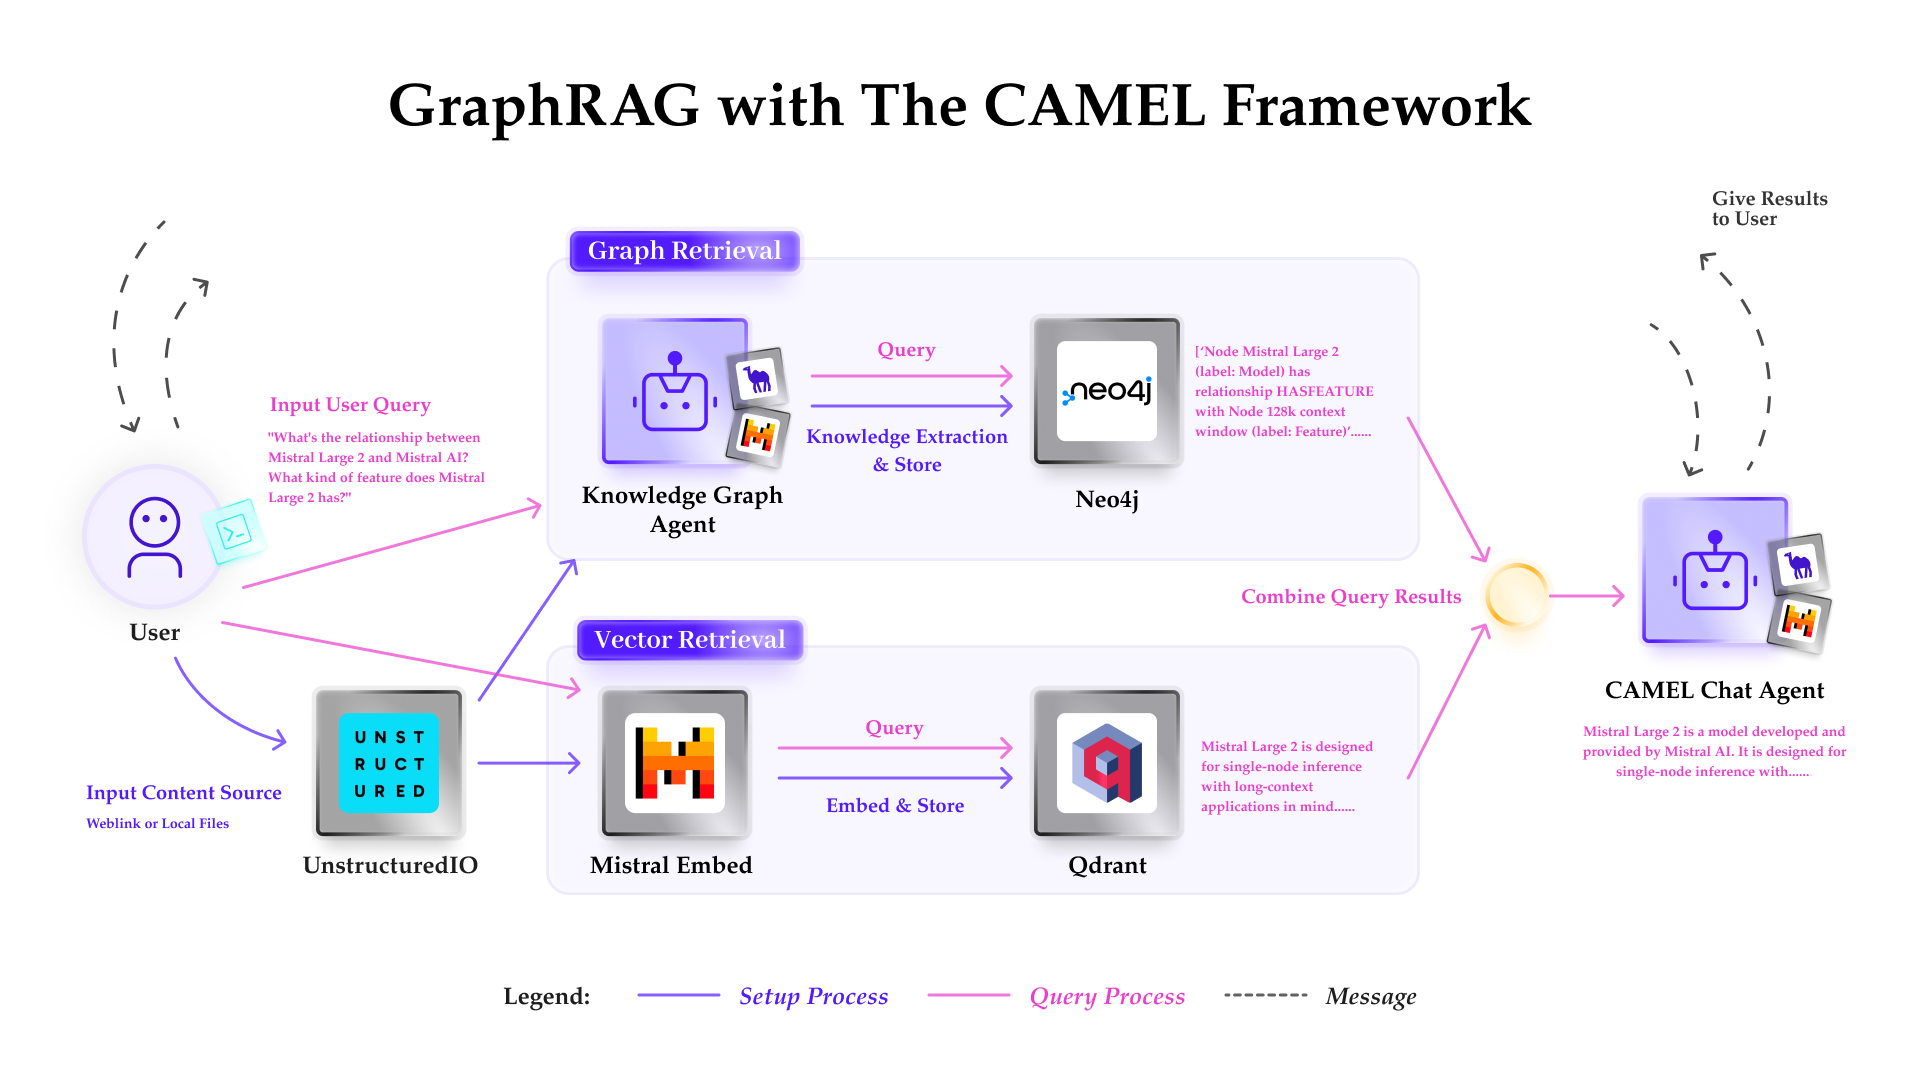

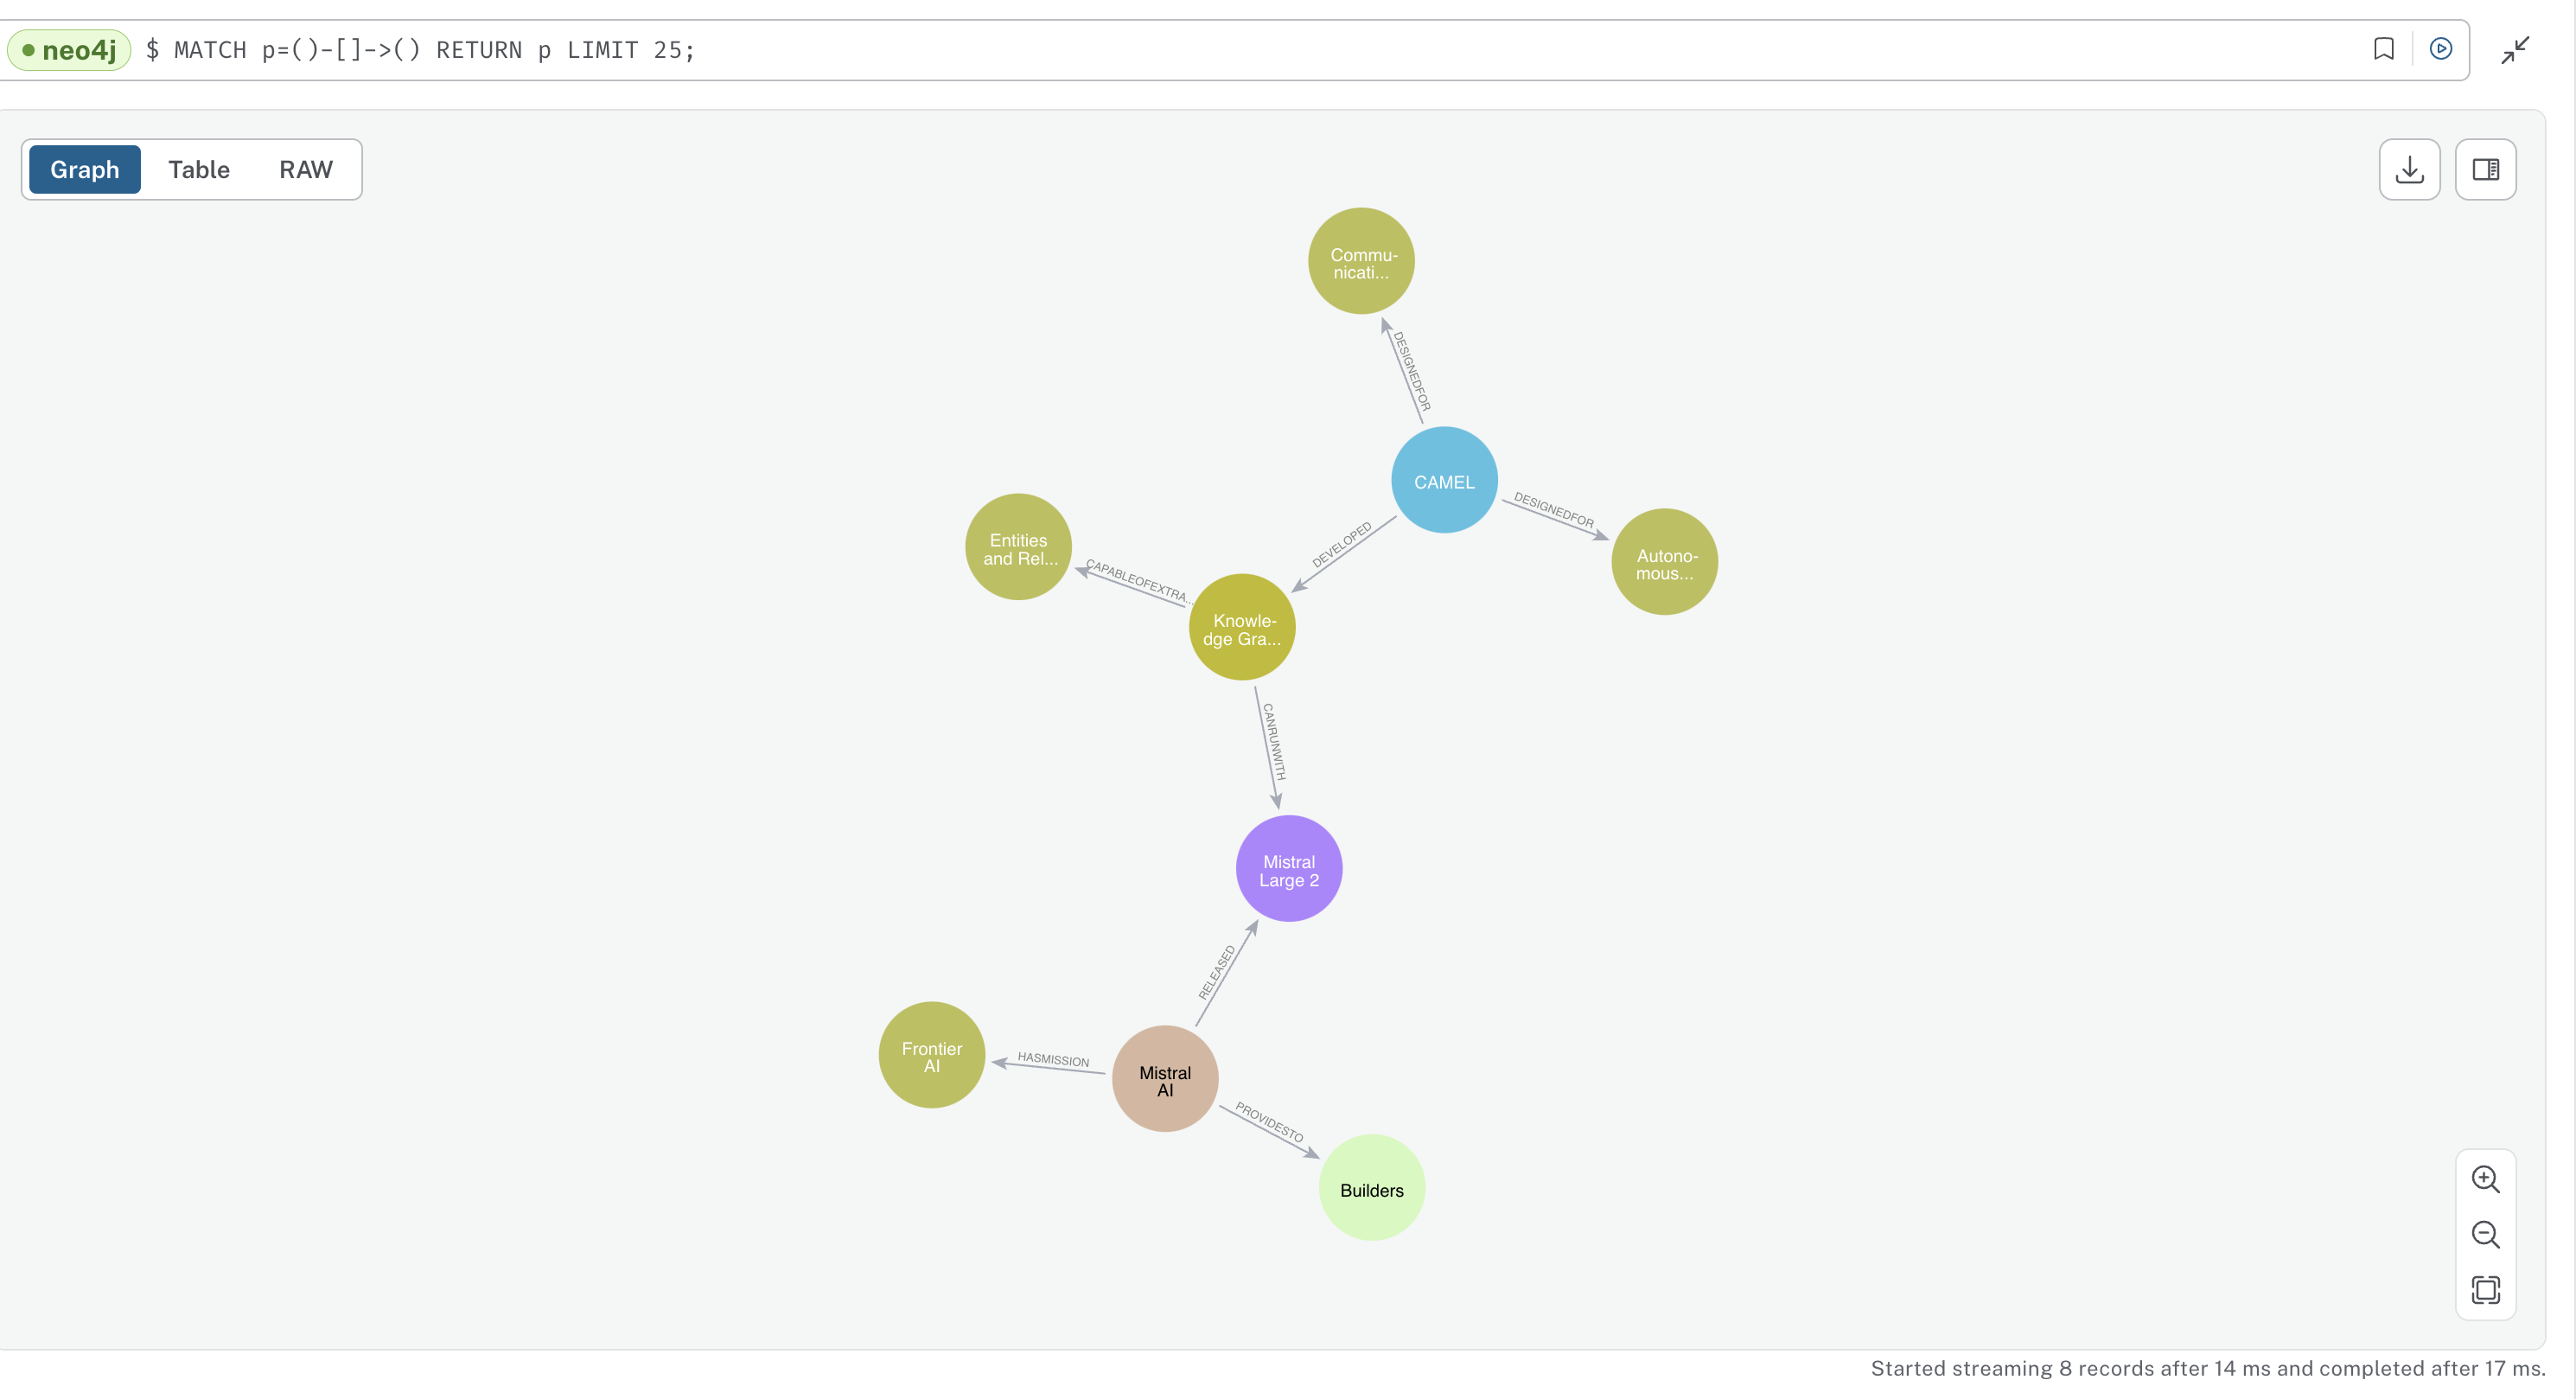

## 📦 Installation

First, install the CAMEL package with all its dependencies:

In [ ]:
pip install "camel-ai[all]==0.2.9"

## 🔧 Setup

Import the required modules from CAMEL-AI:

In [2]:
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType
from camel.configs import MistralConfig, OllamaConfig
from camel.loaders import UnstructuredIO
from camel.storages import Neo4jGraph
from camel.retrievers import AutoRetriever
from camel.embeddings import MistralEmbedding
from camel.types import StorageType
from camel.agents import ChatAgent, KnowledgeGraphAgent
from camel.messages import BaseMessage

## 🔑 Setting Up API Keys


For secure access to Mistral AI's services, we'll prompt for the API key.

In [3]:
import os
from getpass import getpass

# Prompt for the API key securely
mistral_api_key = getpass('Enter your API key: ')
os.environ["MISTRAL_API_KEY"] = mistral_api_key

Enter your API key: ··········


## 🗄️ Configuring Neo4j Graph Database

Set up your Neo4j instance by providing the URL, username, and password, [here](https://neo4j.com/docs/aura/auradb/getting-started/create-database/) is the guidance, check your credentials in the downloaded .txt file. Note that you may need to wait up to 60 seconds if the instance has just been set up.

In [4]:
# Set Neo4j instance
n4j = Neo4jGraph(
    url="Your_URL",
    username="Your_USERNAME",
    password="Your_PASSWORD",
)

## 🧠 Creating the Model

Set up Mistral Large 2 model using the CAMEL ModelFactory:

In [5]:
# Set up model
mistral_large_2 = ModelFactory.create(
    model_platform=ModelPlatformType.MISTRAL,
    model_type=ModelType.MISTRAL_LARGE,
    model_config_dict=MistralConfig(temperature=0.2).as_dict(),
)

In [ ]:
# You can also set up model locally by using ollama
mistral_large_2_local = ModelFactory.create(
    model_platform=ModelPlatformType.OLLAMA,
    model_type="mistral-large",
    model_config_dict=OllamaConfig(temperature=0.2).as_dict(),
)

## 🤖 Generate a Knowledge Graph Using CAMEL's Agent

Set up instances for knowledge graph agent:

In [7]:
# Set instance
uio = UnstructuredIO()
kg_agent = KnowledgeGraphAgent(model=mistral_large_2)

Provide an example text input that the knowledge graph agent will process:

In [8]:
# Set example text input
text_example = """
CAMEL has developed a knowledge graph agent can run with Mistral AI's most
advanced model, the Mistral Large 2. This knowledge graph agent is capable
of extracting entities and relationships from given content and create knowledge
graphs automaticlly.
"""

Create an element from the text and use the knowledge graph agent to extract node and relationship information:

In [9]:
# Create an element from given text
element_example = uio.create_element_from_text(
    text=text_example, element_id="0"
)

In [10]:
# Let Knowledge Graph Agent extract node and relationship information
ans_element = kg_agent.run(element_example, parse_graph_elements=False)
print(ans_element)

Sure, let's go through the process of extracting nodes and relationships from the given content and structuring them into Node and Relationship objects.

### Content:
"CAMEL has developed a knowledge graph agent that can run with Mistral AI's most advanced model, the Mistral Large 2. This knowledge graph agent is capable of extracting entities and relationships from given content and create knowledge graphs automatically."

### Step-by-Step Extraction:

1. **Identify Entities (Nodes):**
   - CAMEL
   - knowledge graph agent
   - Mistral AI
   - Mistral Large 2
   - entities
   - relationships
   - content
   - knowledge graphs

2. **Categorize Entities:**
   - CAMEL: Organization
   - knowledge graph agent: Software
   - Mistral AI: Organization
   - Mistral Large 2: Model
   - entities: Concept
   - relationships: Concept
   - content: Concept
   - knowledge graphs: Concept

3. **Identify Relationships:**
   - CAMEL developed knowledge graph agent
   - knowledge graph agent can run wi

In [11]:
# Check graph element
graph_elements = kg_agent.run(element_example, parse_graph_elements=True)
print(graph_elements)

nodes=[Node(id='CAMEL', type='Organization', properties={'source': 'agent_created'}), Node(id='knowledge graph agent', type='Software', properties={'source': 'agent_created'}), Node(id='Mistral AI', type='Organization', properties={'source': 'agent_created'}), Node(id='Mistral Large 2', type='Model', properties={'source': 'agent_created'}), Node(id='entities and relationships', type='Concept', properties={'source': 'agent_created'}), Node(id='knowledge graphs', type='Concept', properties={'source': 'agent_created'})] relationships=[Relationship(subj=Node(id='CAMEL', type='Organization', properties={'source': 'agent_created'}), obj=Node(id='knowledge graph agent', type='Software', properties={'source': 'agent_created'}), type='Developed', properties={'source': 'agent_created'}), Relationship(subj=Node(id='knowledge graph agent', type='Software', properties={'source': 'agent_created'}), obj=Node(id='Mistral AI', type='Organization', properties={'source': 'agent_created'}), type='CanRunWi

Add the extracted graph elements to the Neo4j database:

In [12]:
# Add the element to neo4j database
n4j.add_graph_elements(graph_elements=[graph_elements])

### 🎉 Now you can go to [here](https://workspace-preview.neo4j.io/connection/connect) to check the knowledge graph built with CAMEL's Knowledge Graph Agent and Mistral AI's Mistral Large 2 model!

## 🗃️ Running Graph RAG with CAMEL

*Next we will showcase how to run RAG in a hybrid approach, combining vector retrieval and knowledge graph retrieval, to query and explore the stored knowledge.*

Set up a vector retriever with local storage and embedding model from Mistral AI:

In [13]:
# Set retriever
camel_retriever = AutoRetriever(
    vector_storage_local_path="local_data/embedding_storage",
    storage_type=StorageType.QDRANT,
    embedding_model=MistralEmbedding(),
)

Provide an example user query:

In [14]:
# Set one user query
query="what's the relationship between Mistral Large 2 and Mistral AI? What kind of feature does Mistral Large 2 has?"

Retrieve related content using the vector retriever, here we take Mistral AI's news in the website as example conetent, you can also set the local file path here:

In [15]:
# Get related content by using vector retriever
vector_result = camel_retriever.run_vector_retriever(
    query=query,
    contents="https://mistral.ai/news/mistral-large-2407/",
)

# Show the result from vector search
print(vector_result)

{'Original Query': "what's the relationship between Mistral Large 2 and Mistral AI? What kind of feature does Mistral Large 2 has?", 'Retrieved Context': ['Large Enough\n\nToday, we are announcing Mistral Large 2, the new generation of our flagship model. Compared to its predecessor, Mistral Large 2 is significantly more capable in code generation, mathematics, and reasoning. It also provides a much stronger multilingual support, and advanced function calling capabilities.\n\nJuly 24, 2024\n\nMistral AI team']}


Parse content from the specified URL and create knowledge graph data:

In [16]:
# Parse conetent from mistral website and create knowledge graph data by using
# the Knowledge Graph Agent, store the information into graph database.

elements = uio.parse_file_or_url(
    input_path="https://mistral.ai/news/mistral-large-2407/"
)
chunk_elements = uio.chunk_elements(
    chunk_type="chunk_by_title", elements=elements
)

graph_elements = []
for chunk in chunk_elements:
    graph_element = kg_agent.run(chunk, parse_graph_elements=True)
    n4j.add_graph_elements(graph_elements=[graph_element])
    graph_elements.append(graph_element)

Create an element from the user query:

In [17]:
# Create an element from user query
query_element = uio.create_element_from_text(
    text=query, element_id="1"
)

# Let Knowledge Graph Agent extract node and relationship information from the qyery
ans_element = kg_agent.run(query_element, parse_graph_elements=True)

Match entities from the query in the knowledge graph storage content:

In [18]:
# Match the enetity got from query in the knowledge graph storage content
kg_result = []
for node in ans_element.nodes:
    n4j_query = f"""
MATCH (n {{id: '{node.id}'}})-[r]->(m)
RETURN 'Node ' + n.id + ' (label: ' + labels(n)[0] + ') has relationship ' + type(r) + ' with Node ' + m.id + ' (label: ' + labels(m)[0] + ')' AS Description
UNION
MATCH (n)<-[r]-(m {{id: '{node.id}'}})
RETURN 'Node ' + m.id + ' (label: ' + labels(m)[0] + ') has relationship ' + type(r) + ' with Node ' + n.id + ' (label: ' + labels(n)[0] + ')' AS Description
"""
    result = n4j.query(query=n4j_query)
    kg_result.extend(result)

kg_result = [item['Description'] for item in kg_result]

# Show the result from knowledge graph database
print(kg_result)

['Node Mistral Large 2 (label: Model) has relationship SUCCESSOROF with Node Mistral Large (label: Model)', 'Node Mistral Large 2 (label: Model) has relationship ANNOUNCEDBY with Node Mistral AI team (label: Organization)', 'Node Mistral Large 2 (label: Model) has relationship HASCAPABILITY with Node code generation (label: Capability)', 'Node Mistral Large 2 (label: Model) has relationship HASCAPABILITY with Node mathematics (label: Capability)', 'Node Mistral Large 2 (label: Model) has relationship HASCAPABILITY with Node reasoning (label: Capability)', 'Node Mistral Large 2 (label: Model) has relationship HASCAPABILITY with Node Instruction-following capabilities (label: Capability)', 'Node Mistral Large 2 (label: Model) has relationship HASCAPABILITY with Node Conversational capabilities (label: Capability)', 'Node Mistral Large 2 (label: Model) has relationship PROVIDES with Node multilingual support (label: Capability)', 'Node Mistral Large 2 (label: Model) has relationship PROVI

Combine results from the vector search and knowledge graph entity search:

In [19]:
# combine result from vector seach and knowledge graph entity search
comined_results = str(vector_result) + "\n".join(kg_result)

Set up an assistant agent to answer questions based on the retrieved context:

In [20]:
# Set agent
sys_msg = BaseMessage.make_assistant_message(
    role_name="CAMEL Agent",
    content="""You are a helpful assistant to answer question,
        I will give you the Original Query and Retrieved Context,
    answer the Original Query based on the Retrieved Context.""",
)

camel_agent = ChatAgent(system_message=sys_msg,
                        model=mistral_large_2)

# Pass the retrieved infomation to agent
user_prompt=f"""
The Original Query is {query}
The Retrieved Context is {comined_results}
"""

user_msg = BaseMessage.make_user_message(
    role_name="CAMEL User", content=user_prompt
)

# Get response
agent_response = camel_agent.step(user_msg)

print(agent_response.msg.content)

Mistral Large 2 is a model developed and provided by Mistral AI. It is the successor to the original Mistral Large model. Mistral Large 2 has several notable features and capabilities, including:

1. **Capabilities**:
   - Code generation
   - Mathematics
   - Reasoning
   - Instruction-following capabilities
   - Conversational capabilities

2. **Multilingual Support**:
   - Provides strong multilingual support for languages such as French, German, Spanish, Italian, Portuguese, Arabic, Hindi, Russian, Chinese, Japanese, Korean, English, and Dutch.

3. **Advanced Function Calling Capabilities**:
   - Equipped with enhanced function calling and retrieval skills.
   - Trained to execute parallel and sequential function calls.

4. **Context Window**:
   - Has a 128k context window.

5. **Coding Language Support**:
   - Supports coding languages like Python, Java, C, C++, JavaScript, and Bash.

6. **Design**:
   - Designed for single-node inference and long-context applications.

7. **Attr

## 🌟 Highlights

*   Automated Knowledge Extraction: The Knowledge Graph Agent automates the extraction of entities and relationships, making the process efficient and effective.

*   Mistral AI Integration: This cookbook showcases the integration of Mistral AI's advanced models, particularly the Mistral Large 2, with CAMEL-AI to create a powerful knowledge graph system.


*   Secure and Scalable: Using CAMEL-AI's robust architecture and Neo4j for graph storage ensures that the solution is both secure and scalable.

By following this cookbook, you can leverage the cutting-edge capabilities of **CAMEL AI** and **Mistral AI** to build sophisticated knowledge graphs, facilitating advanced data analysis and retrieval tasks.